In [48]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pybaseball import statcast, playerid_lookup
from statsmodels.graphics.tsaplots import plot_acf
from pybaseball import playerid_lookup, statcast_pitcher
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Function to fetch an entire season 
def fetch_season_data_simple(year, season_start="04-01", season_end="10-01"):
    start_date = f"{year}-{season_start}"
    end_date   = f"{year}-{season_end}"
    try:
        season_data = statcast(start_date, end_date)
        season_data['game_date'] = pd.to_datetime(season_data['game_date'])
    except Exception as e:
        season_data = pd.DataFrame()
    return season_data


years = [2018,2019,2021,2022,2023]
data_list = []

for i in years:
    season_data = fetch_season_data_simple(i)
    if not season_data.empty:
        data_list.append(season_data)
    else:
        print(f"No data collected for {i}.")

all_data = pd.concat(data_list, axis=0)
print("Total data shape:", all_data.shape)

In [3]:
# Examine columns
for col in all_data.columns:
    print(col) 

pitch_type
game_date
release_speed
release_pos_x
release_pos_z
player_name
batter
pitcher
events
description
spin_dir
spin_rate_deprecated
break_angle_deprecated
break_length_deprecated
zone
des
game_type
stand
p_throws
home_team
away_team
type
hit_location
bb_type
balls
strikes
game_year
pfx_x
pfx_z
plate_x
plate_z
on_3b
on_2b
on_1b
outs_when_up
inning
inning_topbot
hc_x
hc_y
tfs_deprecated
tfs_zulu_deprecated
umpire
sv_id
vx0
vy0
vz0
ax
ay
az
sz_top
sz_bot
hit_distance_sc
launch_speed
launch_angle
effective_speed
release_spin_rate
release_extension
game_pk
fielder_2
fielder_3
fielder_4
fielder_5
fielder_6
fielder_7
fielder_8
fielder_9
release_pos_y
estimated_ba_using_speedangle
estimated_woba_using_speedangle
woba_value
woba_denom
babip_value
iso_value
launch_speed_angle
at_bat_number
pitch_number
pitch_name
home_score
away_score
bat_score
fld_score
post_away_score
post_home_score
post_bat_score
post_fld_score
if_fielding_alignment
of_fielding_alignment
spin_axis
delta_home_win_exp
d

In [ ]:

out_events = [
    'strikeout', 'field_out', 'grounded_into_double_play', 'double_play',
    'force_out', 'flyout', 'lineout', 'pop_out', 'sac_fly', 'sac_bunt', 'triple_play'
]
pitcher_data['is_out'] = pitcher_data['events'].isin(out_events).astype(int)
pitcher_data['in_zone'] = pitcher_data['zone'].between(1, 9).fillna(False).astype(int)

outs_per_game = pitcher_data.groupby('game_date')['is_out'].sum().reset_index()
outs_per_game['innings_pitched'] = outs_per_game['is_out'] / 3

zone_rate_per_game = pitcher_data.groupby('game_date')['in_zone'].mean().reset_index(name='zone_rate')


# Aggregating data by game to prepare our features for analysis. 
game_data = pitcher_data.groupby('game_date').agg({
    'pitch_type': np.size,
    'events': lambda x: np.sum(x == 'strikeout'),
    'release_speed': np.mean,
    'release_spin_rate': np.mean,
    'pitcher_days_since_prev_game': np.mean,
    'spin_axis': np.mean,
    'release_pos_x': np.mean,
    'pitch_number': np.mean,
    'release_extension': np.mean
}).reset_index()

game_data = game_data.rename(columns={
    'pitch_type': 'total_pitches',
    'events': 'strikeouts',
    'release_speed': 'avg_velocity',
    'release_spin_rate': 'avg_spin_rate',
    'pitcher_days_since_prev_game': 'rest_days',
    'spin_axis': 'avg_spin_axis',
    'release_pos_x': 'avg_release_pos_x',
    'pitch_number': 'avg_pitch_number',
    'release_extension': 'avg_release_extension'
})

# Merge with innings pitched and zone rate
game_data = pd.merge(game_data, outs_per_game[['game_date', 'innings_pitched']], on='game_date', how='left')
game_data = pd.merge(game_data, zone_rate_per_game, on='game_date', how='left')
game_data = game_data.sort_values('game_date').reset_index(drop=True)


/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_22075/1267788064.py:15: FutureWarning: The provided callable <function mean at 0x106b6a9d0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  game_data = pitcher_data.groupby('game_date').agg({


In [272]:
# Defining time series weekly and defining strike outs per 9 innings

def get_season_base(year):
    return pd.to_datetime(f'{year}-04-01').isocalendar().week

game_data['year'] = game_data['game_date'].dt.year
game_data['week_of_year'] = game_data['game_date'].dt.isocalendar().week
game_data['season_base'] = game_data['year'].apply(get_season_base)
game_data['week_of_season'] = game_data['week_of_year'] - game_data['season_base'] + 1
season_map = {2018: 1, 2019: 2, 2021: 3, 2022: 4, 2023: 5}
game_data['season'] = game_data['year'].map(season_map)
game_data['weekx'] = game_data['season'] * 100 + game_data['week_of_season']

weekly_data = game_data.groupby('weekx').agg({
    'game_date': min,
    'total_pitches': np.sum,
    'strikeouts': np.sum,
    'innings_pitched': np.sum,
    'avg_velocity': np.mean,
    'avg_spin_rate': np.mean,
    'avg_spin_axis': np.mean,
    'zone_rate': np.mean,
    'rest_days': np.mean,
    'avg_release_pos_x': np.mean, 
    'avg_pitch_number': np.mean, 
    'avg_release_extension': np.mean
}).reset_index()



weekly_data['K_per_9'] = (weekly_data['strikeouts'] / weekly_data['innings_pitched']) * 9
weekly_data = weekly_data.sort_values('game_date').reset_index(drop=True)
weekly_data['linear_week'] = np.arange(1, len(weekly_data) + 1)
print(weekly_data.head())
weekly_data.to_csv("weekly_data_for_r.csv", index=False)

print("CSV file 'weekly_data_for_r.csv' has been created.")


   weekx  game_date  total_pitches  strikeouts  innings_pitched  avg_velocity  \
0  102.0 2018-04-04            110           7         5.000000     88.834545   
1  103.0 2018-04-09            205          21        15.666667     89.355349   
2  104.0 2018-04-20            106           9         5.666667     89.132075   
3  105.0 2018-04-25             99          10         6.000000      88.59798   
4  106.0 2018-05-01            217          23        12.333333     89.443647   

   avg_spin_rate  avg_spin_axis  zone_rate  rest_days  avg_release_pos_x  \
0    2334.587156     195.836364   0.509091        5.0          -3.678455   
1    2382.403725     188.489197   0.522130        5.0          -3.539745   
2    2396.769231     190.122642   0.566038        6.0          -3.584906   
3    2336.102041     191.747475   0.505051        5.0          -3.624545   
4    2322.456761     194.947603   0.520483        5.5          -3.578044   

   avg_pitch_number  avg_release_extension    K_per_9  l

/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_22075/1764530284.py:14: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  weekly_data = game_data.groupby('weekx').agg({
/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_22075/1764530284.py:14: FutureWarning: The provided callable <function sum at 0x106b66550> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  weekly_data = game_data.groupby('weekx').agg({
/var/folders/g8/kwj12nxd4gz7y8146hsnf5940000gn/T/ipykernel_22075/1764530284.py:14: FutureWarning: The provided callable <function mean at 0x106b6a9d0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To

In [262]:

# Base line model - no exog features
y = weekly_data['K_per_9'].dropna().astype(float)

model_baseline = SARIMAX(
    endog=y,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)


print("Baseline ARIMA(1,1,1) AIC:", model_baseline.aic)




Baseline ARIMA(1,1,1) AIC: 482.0435739509706


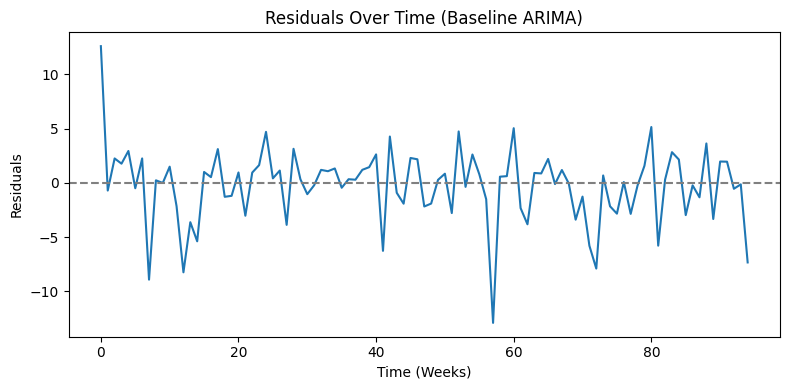

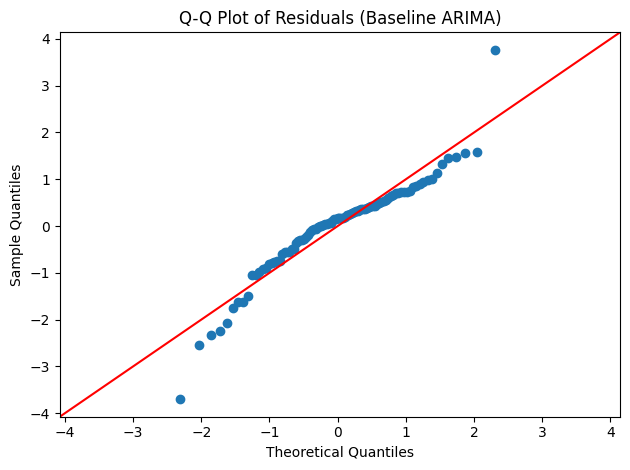

In [263]:
residuals = model_baseline.resid

plt.figure(figsize=(8, 4))
plt.plot(residuals)
plt.title("Residuals Over Time (Baseline ARIMA)")
plt.xlabel("Time (Weeks)")
plt.ylabel("Residuals")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (Baseline ARIMA)")
plt.tight_layout()
plt.show()


In [ ]:
# ARIMAX With exog features

# Testing out some features we might think will help 
exog_vars = [
    'avg_velocity', 'avg_release_pos_x', 'avg_spin_rate', 'avg_pitch_number',
    'avg_release_extension', 'rest_days', 'zone_rate'
]

X_exog = weekly_data[exog_vars].astype(float)
y = weekly_data['K_per_9'].astype(float)

aligned = pd.concat([y, X_exog], axis=1).dropna()
y_final = aligned['K_per_9']
X_final = aligned.drop(columns='K_per_9')

model_exog = SARIMAX(
    endog=y_final,
    exog=X_final,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Print AIC
print("SARIMAX AIC :", model_exog.aic)
print(model_exog.summary())

SARIMAX AIC : 492.5616409736548
                               SARIMAX Results                                
Dep. Variable:                K_per_9   No. Observations:                   95
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -236.281
Date:                Fri, 11 Apr 2025   AIC                            492.562
Time:                        17:06:25   BIC                            517.780
Sample:                             0   HQIC                           502.740
                                 - 95                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
avg_velocity              0.1787      0.391      0.457      0.648      -0.588       0.945
avg_release_pos_x        -6.3991      3.386     -1.890      0.059 

/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [270]:
exog_vars = [
    'avg_release_pos_x','rest_days'
]

X_exog = weekly_data[exog_vars].astype(float)
y = weekly_data['K_per_9'].astype(float)

aligned = pd.concat([y, X_exog], axis=1).dropna()
y_final = aligned['K_per_9']
X_final = aligned.drop(columns='K_per_9')

# Fit SARIMAX model
model_exog_release_rest = SARIMAX(
    endog=y_final,
    exog=X_final,
    order=(1, 1, 1),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

# Print AIC
print("SARIMAX AIC :", model_exog_release_rest.aic)
print(model_exog_release_rest.summary())

SARIMAX AIC : 481.6150600272447
                               SARIMAX Results                                
Dep. Variable:                K_per_9   No. Observations:                   95
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -235.808
Date:                Fri, 11 Apr 2025   AIC                            481.615
Time:                        17:09:46   BIC                            494.224
Sample:                             0   HQIC                           486.704
                                 - 95                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
avg_release_pos_x    -3.7297      1.803     -2.068      0.039      -7.264      -0.195
rest_days            -0.1849      0.108     -1.705      0.088      -0.397     

In [260]:
# Rest Days and avg_release_pos_x are the most promising features out of the ones we have tested. 



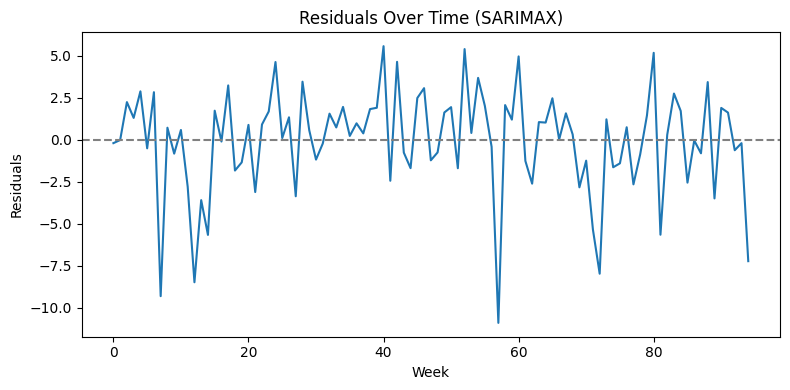

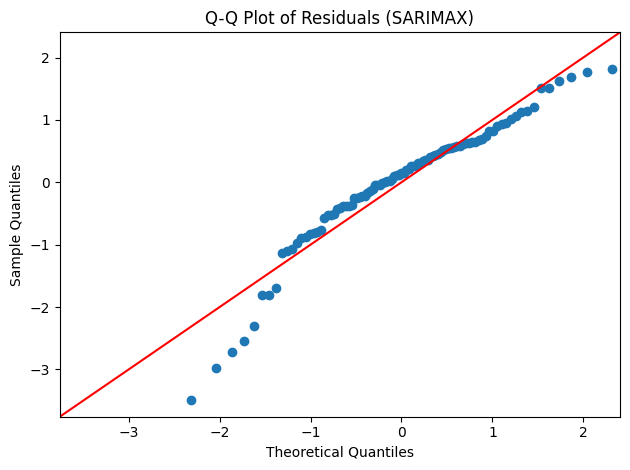

   Actual_K_per_9  Predicted_K_per_9
0           12.60              12.80
1           12.06              12.07
2           14.29              12.05
3           15.00              13.69
4           16.78              13.89
5           14.14              14.65
6           16.71              13.87
7            6.00              15.31
8           13.50              12.78
9           13.50              14.32


In [271]:
residuals = model_exog_release_rest.resid

plt.figure(figsize=(8, 4))
plt.plot(residuals)
plt.title("Residuals Over Time (SARIMAX)")
plt.xlabel("Week")
plt.ylabel("Residuals")
plt.axhline(0, linestyle='--', color='gray')
plt.tight_layout()
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals (SARIMAX)")
plt.tight_layout()
plt.show()

predicted = model_exog_release_rest.predict(start=0, end=len(y_final)-1, exog=X_final, dynamic=False)

comparison_df = pd.DataFrame({
    'Actual_K_per_9': y_final.values,
    'Predicted_K_per_9': predicted.values
}).round(2)

print(comparison_df.head(10)) 